#### 1 任务概览：数据集长什么样子

MNIST 手写数字数据集来源于是美国国家标准与技术研究所，是著名的公开数据集之一，通常这个数据集都会被作为深度学习的入门案例。数据集中的数字图片是由 250 个不同职业的人纯手写绘制，数据集获取的网址为：http://yann.lecun.com/exdb/mnist。

我们这里则直接从 torchvision 下载该数据集。MNIST 手写数字数据集包含有 60000 张图片作为训练集数据，10000 张图片作为测试集数据（典型的监督学习问题，属于计算机视觉任务领域），且每一个训练元素都是 28*28 像素的手写数字图片，每一张图片代表的是从 0 到 9 中的每个数字。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [3]:
len(trainloader) * 64, len(testloader) * 64

(60032, 10048)

如果我们把每一张图片中的像素转换为向量，则得到长度为 28*28=784 的向量。因此我们可以把 MNIST 数据训练集看作是一个 [60000,784] 的张量，第一个维度表示图片的索引，第二个维度表示每张图片中的像素点。而图片里的每个像素点的值介于 0-1 之间。MNIST 数据集的类标是介于 0-9 的数字，共 10 个类别。

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

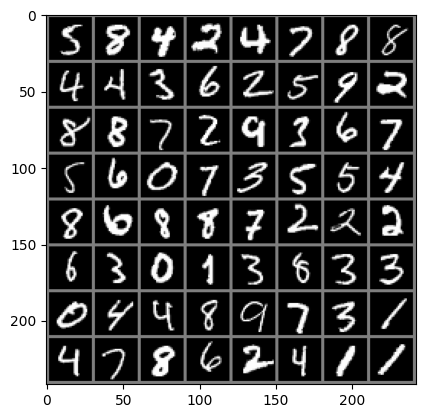

In [5]:
images = torchvision.utils.make_grid(images)
images = (images / 2 + 0.5).numpy()
plt.imshow(np.transpose(images, (1, 2, 0)), cmap='gray')
plt.show()

In [6]:
np.array([labels[j].item() for j in range(64)]).reshape(8, 8)

array([[5, 8, 4, 2, 4, 7, 8, 8],
       [4, 4, 3, 6, 2, 5, 9, 2],
       [8, 8, 7, 2, 9, 3, 6, 7],
       [5, 6, 0, 7, 3, 5, 5, 4],
       [8, 6, 8, 8, 7, 2, 2, 2],
       [6, 3, 0, 1, 3, 8, 3, 3],
       [0, 4, 4, 8, 9, 7, 3, 1],
       [4, 7, 8, 6, 2, 4, 1, 1]])

#### 2 设计你的第一个模型：卷积神经网络

卷积神经网络（CNN）是一种深度学习模型，广泛用于图像分类、目标检测等任务。CNN 的特点是通过卷积层提取局部特征，然后逐步聚合成高层次特征，最终用于分类。
- 卷积层：通过卷积操作提取局部特征，是 CNN 的核心组件。通常会搭配 ReLU 激活函数引入非线性。
- 池化层：通过最大池化操作减少特征图的尺寸，同时保留重要特征，有助于降低模型计算量和防止过拟合。
- 全连接层：将卷积层提取的高层次特征进行整合，最终输出分类结果。

我们这里的 CNN 模型包含两个卷积层和两个全连接层，具体结构如下：
- 输入层: 输入的图像是单通道的 28x28 灰度图像（来自 MNIST 数据集），尺寸为 [1, 28, 28]。
- 第一个卷积层 (conv1): 输入通道数为 1（因为是灰度图像），输出通道数为 32。卷积核大小为 3x3，步长为 1，无填充（padding）。输出尺寸为 [32, 26, 26]（经过卷积后图像尺寸变为 26x26）。激活函数为 ReLU，用于引入非线性。
- 第二个卷积层 (conv2): 输入通道数为 32，输出通道数为 64。卷积核大小为 3x3，步长为 1，无填充。输出尺寸为 [64, 24, 24]。激活函数为 ReLU。
- 最大池化层 (max_pool2d): 进行 2x2 的最大池化操作，步长为 2。这会将输出尺寸减少一半，即变为 [64, 12, 12]。
- 第一个全连接层 (fc1): 输入节点数为 641212（经过前面卷积和池化后的展平操作）。输出节点数为 128。激活函数为 ReLU。
- 第二个全连接层 (fc2): 输入节点数为 128，输出节点数为 10（对应于 10 个类别）。使用 log_softmax 函数将输出转换为对数概率。

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class VanillaCNN(nn.Module):
    def __init__(self):
        super(VanillaCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

当然，了解卷积层和池化层的计算原理以及参数量的计算方法对于设计和调试卷积神经网络（CNN）非常重要。下面我们详细讲解这些计算过程。

##### 1. 卷积层的输出尺寸计算

- 输入图像尺寸为 $ H_{in} \times W_{in} $
- 卷积核大小为 $ K \times K $ （通常是方形的）
- 填充为 $ P $
- 步长为 $ S $
- 输出通道数为 $ C_{out} $

卷积层输出的高和宽可以通过以下公式计算：

$
H_{out} = \frac{H_{in} - K + 2P}{S} + 1
$

$
W_{out} = \frac{W_{in} - K + 2P}{S} + 1
$

##### 2. 池化层的输出尺寸计算

池化层通常用于下采样，它会缩小特征图的尺寸，但不会改变通道数。常见的池化操作包括最大池化（Max Pooling）和平均池化（Average Pooling）。
池化层输出的高和宽计算公式与卷积层类似，区别只是池化核大小为 $ K \times K $：

$
H_{out} = \frac{H_{in} - K + 2P}{S} + 1
$

$
W_{out} = \frac{W_{in} - K + 2P}{S} + 1
$

让我们看看模型的参数量是多少。`model.parameters()` 返回模型中所有参数的生成器。

In [8]:
model = VanillaCNN()
count_params = lambda model: sum(p.numel() for p in model.parameters() if p.requires_grad)
count_params(model)

1199882

CNN 中的参数量主要来自两个地方：卷积层和全连接层。
卷积层的参数量计算公式为：

$
\text{参数量} = \left(K \times K \times C_{in} \times C_{out}\right) + C_{out}
$

其中：
- $ K \times K $ 是卷积核的尺寸。
- $ C_{in} $ 是输入通道数。
- $ C_{out} $ 是输出通道数。
- 最后的 $ + C_{out} $ 是每个输出通道的偏置项（bias）。

在我们所设计的 CNN 中：

- **第一层卷积（conv1）**：
  - 输入通道数：1
  - 输出通道数：32
  - 卷积核大小：3 × 3
  - 参数量：$(3 \times 3 \times 1 \times 32) + 32 = 320$
- **第二层卷积（conv2）**：
  - 输入通道数：32
  - 输出通道数：64
  - 卷积核大小：3 × 3
  - 参数量：$(3 \times 3 \times 32 \times 64) + 64 = 18,496$
- **全连接层（fc1）**：
  - 输入节点数：64 × 12 × 12（假设池化后尺寸为 12 × 12）
  - 输出节点数：128
  - 参数量：$64 \times 12 \times 12 \times 128 + 128 = 1,179,776$
- **全连接层（fc2）**：
  - 输入节点数：128
  - 输出节点数：10
  - 参数量：$128 \times 10 + 10 = 1,290$

总和为 320 + 18496 + 1179776 + 1290 = 1199882 与实验结果一致。

#### 3 损失函数和优化器

随机梯度下降（SGD）是一种常用的优化算法，用于训练神经网络模型。它通过逐步调整模型参数，使损失函数的值逐渐减小，从而优化模型的性能。梯度下降的核心思想是通过计算损失函数对模型参数的梯度，沿着梯度的反方向调整参数，使得损失函数值逐步减少。标准的梯度下降算法在每一步都会使用整个训练集来计算梯度，而 SGD 则在每一步中只使用一个或一小部分样本（称为 mini-batch）来更新参数。公式如下：

$ \theta = \theta - \eta \cdot \nabla_\theta J(\theta; x_i, y_i) $

其中：
- $ \theta $ 表示模型的参数。
- $ \eta $ 是学习率，控制每次更新的步长。
- $ \nabla_\theta J(\theta; x_i, y_i) $ 是损失函数对参数 $ \theta $ 的梯度。

SGD 通过在每一步中引入随机性，有助于跳出局部最优解，并提高训练效率。

交叉熵损失函数是深度学习中广泛使用的一种损失函数，特别适用于分类问题。它用于衡量预测的概率分布与真实分布之间的差异。
交叉熵损失的目标是最小化模型预测的概率分布与实际分布（通常是one-hot编码的真实标签）之间的差异。对于分类问题，给定模型的输出概率分布 $ p $ 和真实分布 $ q $，交叉熵 $ H(p, q) $ 定义如下：

$ H(p, q) = -\sum_{i=1}^{n} q_i \log(p_i) $

在实际中，对于单个样本 $ x $，交叉熵损失通常表示为 $ \text{Loss}(x) = -\log(p_{y}) $ 其中，$ p_{y} $ 是模型预测的真实类别 $ y $ 的概率。
在 PyTorch 中，`nn.CrossEntropyLoss` 是一个集成了 `softmax` 操作和交叉熵计算的模块。它期望输入的 logits（未经 softmax 的输出）和真实的类别索引。
交叉熵损失函数通常用于多分类问题（例如 MNIST 手写数字识别），其中模型需要在多个类别中进行选择。

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

#### 4 开始训练和评估！

我们首先实现两个函数分别用于训练模型和测试模型的表现。

注意到，如果 test 函数的 `test_loader=trainloader` 则该函数用于验证（validation），否则用于在 heldout 上测试分数。

In [20]:
from tqdm import tqdm # `!pip install tqdm` if needed

def train(model, device, train_loader, optimizer, epoch, history=None):
    model.train()
    running_loss = 0.0
    total_batches = len(train_loader)
    
    progress_bar = tqdm(enumerate(train_loader), total=total_batches, desc=f'Epoch {epoch}/{num_epochs}')

    for batch_idx, (data, target) in progress_bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/(batch_idx+1))

    avg_loss = running_loss / total_batches
    if history is not None:
        history.append(avg_loss)

    # print(f'\nEpoch {epoch}: Average loss: {avg_loss:.6f}')
    return avg_loss

In [21]:
from tqdm import tqdm

def test(model, device, test_loader, history=None):
    model.eval()
    test_loss = 0
    correct = 0
    total_batches = len(test_loader)
    
    progress_bar = tqdm(enumerate(test_loader), total=total_batches, desc='Testing')

    with torch.no_grad():
        for batch_idx, (data, target) in progress_bar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            # print(target.shape, output.shape)
            # correct += (pred == target).sum().item()
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            progress_bar.set_postfix(loss=test_loss / (batch_idx + 1))

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    if history is not None:
        history.append((test_loss, accuracy))

    # print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
    #       f' ({accuracy:.0f}%)\n')
    return test_loss, accuracy

终于，我们开始训练模型。

Epoch 5/5: 100%|██████████| 938/938 [00:09<00:00, 99.96it/s, loss=0.0164] 


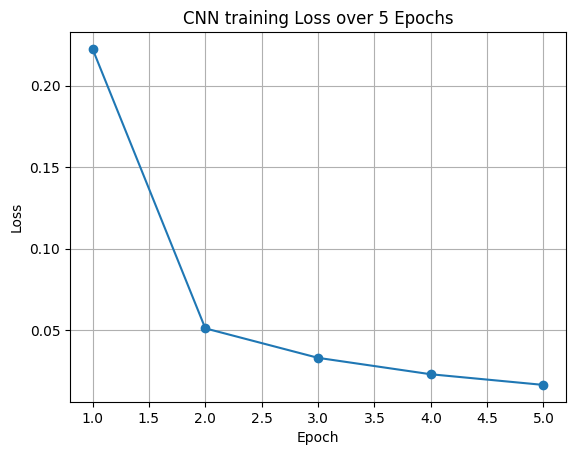

In [23]:
import matplotlib.pyplot as plt

train_loss_history = []

model = VanillaCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5
for epoch in range(1, num_epochs + 1):
    train(model, device, trainloader, optimizer, epoch, history=train_loss_history)
    
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o')
plt.title(f'CNN training Loss over {num_epochs} Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

之后是测试训练好的模型在 heldout testset 上的表现。注意，我们的**评估指标**自然是准确率了，也就是 `correct += pred.eq(target.view_as(pred)).sum().item()`。

In [26]:
test_loss_history = []
test_loss, test_accuracy = test(model, device, testloader, history=test_loss_history)
round(test_loss, 6), test_accuracy

Testing: 100%|██████████| 157/157 [00:01<00:00, 117.03it/s, loss=0.0372]


(0.000585, 98.87)

In [27]:
import matplotlib.pyplot as plt

def visualize_predictions(model, device, test_loader):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    output = model(images)
    _, preds = torch.max(output, 1)
    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        plt.title(f'Pred: {preds[i].item()} (True: {labels[i].item()})')
        plt.axis('off')
    plt.show()

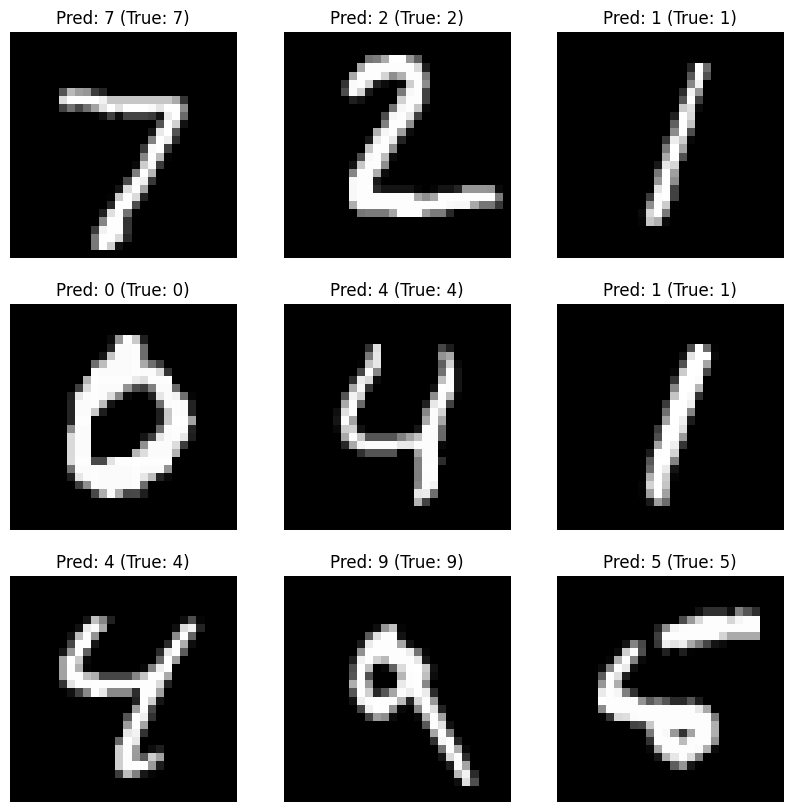

In [28]:
visualize_predictions(model, device, test_loader=testloader)

消融实验（调整如下的参数，看看实验结果的高低比较）
- 不同的学习率：学习率决定了梯度更新的步长，过大会容易不收敛，过小则收敛太慢未到极小点
- 不同的损失函数：实际上 CE loss 就是多分类任务最常用的损失函数了，如果想尝试可以改成 MSELoss（均方误差损失）试试看，但是要将概率输出改成一个值
- `loss = nn.MSELoss()(output, target.float())`
- 不同的优化器：基于动量的优化器如 Adam、RMSprop、Adagrad 等。不同的优化器在不同的任务中可能表现出不同的性能，这取决于它们的更新规则和参数设置。
- `optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))`
- 更深的网络结构：你可以自己设计深度更深的 CNN 网络，或者实现一些论文中的复杂网络；你可以继而改动 epoch 探索模型是否会出现过拟合。

如下的过多 epoch 实验应该可以观察到过拟合的现象。解决方法想必你也知道，更大更优的数据集是第一位的。

Epoch 10/10: 100%|██████████| 938/938 [00:07<00:00, 122.11it/s, loss=0.00345]


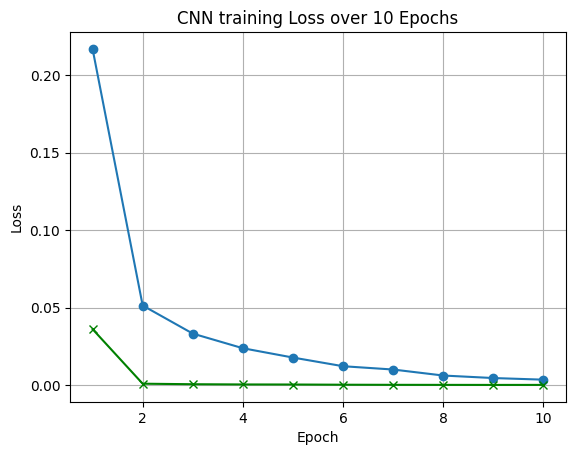

In [19]:
import matplotlib.pyplot as plt

train_loss_history = []
test_loss_history = []

model = VanillaCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    test(model, device, test_loader=trainloader, history=test_loss_history)
    train(model, device, trainloader, optimizer, epoch, history=train_loss_history)
    

plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), [test_loss for (test_loss, accuracy) in test_loss_history], marker='x', color="green", label='Testing Loss')
plt.title(f'CNN training Loss over {num_epochs} Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

如下是非常常用的模型存储和重新加载回来，毕竟我们生在大模型的时代，预训练模型的 post-training 是必不可少的。

In [35]:
import torch
torch.save(model.state_dict(), 'model.pth')

In [36]:
import torch
model = VanillaCNN()
# model.load_state_dict(torch.load('model.pth'))
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cuda')))
model.eval()

VanillaCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### 5 如果用 RNN 怎么样

我们将使用一个简单的 RNN 模型来处理手写数字识别任务。由于 MNIST 数据集中的每张图像是 28×28 的灰度图，我们可以将每一行像素视为一个时间步，这样就有 28 个时间步，每个时间步的输入为 28 维向量。

In [61]:
import torch.nn as nn
import torch.nn.functional as F

class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.squeeze(1) # (64, 1, 28, 28) -> (64, 28, 28)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # [9, 64, 256]
        out, _ = self.rnn(x, h0) # (64, 28, 256)
        out = self.fc(out[:, -1, :])
        return F.log_softmax(out, dim=1)

model = VanillaRNN(input_size=28, hidden_size=256, output_size=10, num_layers=9)
model

VanillaRNN(
  (rnn): RNN(28, 256, num_layers=9, batch_first=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

In [62]:
count_params = lambda model: sum(p.numel() for p in model.parameters() if p.requires_grad)
count_params(model)

1128458

Epoch 10/10: 100%|██████████| 938/938 [00:13<00:00, 69.76it/s, loss=0.281]


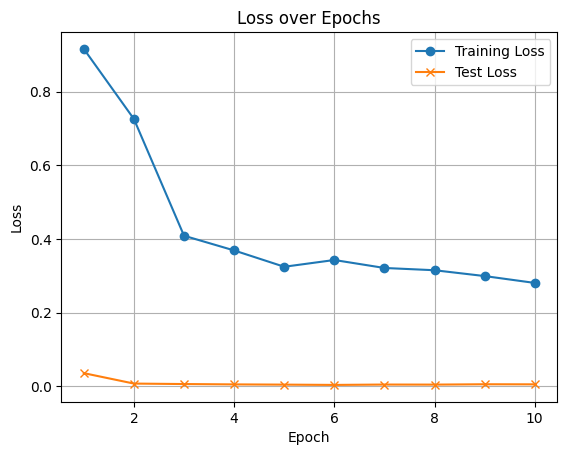

In [63]:
model = VanillaRNN(input_size=28, hidden_size=256, output_size=10, num_layers=9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_history = []
test_loss_history = []

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    test_loss, test_accuracy = test(model, device, testloader, history=test_loss_history)
    train_loss = train(model, device, trainloader, optimizer, epoch, history=train_loss_history)

plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), [loss for loss, acc in test_loss_history], marker='x', label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

尽管在参数量大致相同的情况下，CNN 模型的表现明显优于 RNN 模型。通过归纳偏置（Inductive Bias）的角度，我们可以深入探讨两种模型在该任务中的表现差异。

**归纳偏置的定义**：归纳偏置是指模型对数据的先验假设或内在约束，这些假设和约束引导了模型如何从数据中学习特定模式。不同的模型具有不同的归纳偏置，这会直接影响它们在特定任务中的表现。

CNN 的归纳偏置包括**局部感受野**和**参数共享**，这使得 CNN 特别擅长处理具有空间结构的图像数据。具体而言：
- **局部感受野**：CNN 中的卷积核可以捕捉图像中的局部模式，如边缘、角点等。这些局部特征可以在更高层次被组合成更复杂的图像结构。
- **参数共享**：CNN 的卷积核在图像的不同位置共享相同的参数，这使得模型能够高效地学习到位置不变的特征（如一个数字“2”的形状无论出现在图像的哪个位置，其特征都是相似的）。

RNN 的归纳偏置主要体现在它对**序列数据的处理能力**上。RNN 设计用于处理序列数据，因此在时间步之间的依赖关系（如自然语言处理中的上下文信息）方面表现较好：
- **时间序列的依赖性**：RNN 能够通过隐藏状态捕捉序列数据中前后时间步之间的依赖关系。
- **输入顺序的重要性**：RNN 对输入的顺序敏感，更适合处理输入有明确顺序依赖的任务。

In [66]:
test_loss_history[-1][1]

88.8

#### 6 可选：尝试 ViT (Vision Transformer)
你也可以在 Transformer Encoder 上做相同实验，看看结果如何，并对比时间复杂度是否如论文所说。

参考
https://github.com/UdbhavPrasad072300/Transformer-Implementations/blob/main/notebooks/MNIST%20Classification%20-%20ViT.ipynb